# Accessing APIs in Astronomy

APIs, or Application Program Interfaces, are sets of tools and instructions to access an application. For our purposes here, an API will allow us to access the endpoints of several astronomical catalogs and websites in order to request data through scripts in Python.

First, we'll load up some of the packages that we'll need to use. This includes **urllib** and **ulrlib2** to access URLs; **requests**, which is a better way to do the same; **StringIO** to treat strings as if they were files; **BeautifulSoup** to parse HTML files; **simplejson** to parse JSON files; and **requests_oauthlib** to handle authorization for API requests. We'll also load **matplotlib** for a quick plot and **astropy** to deal with VOTables.

In [1]:
%matplotlib inline

import urllib2, urllib
import requests
from StringIO import StringIO
from astropy.table import Table
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import simplejson
from requests_oauthlib import OAuth1 # used for twitter's api

## IRSA API

Let's look at an example by considering the [IRSA (NASA/IPAC Infrared Science Archive) API](http://irsa.ipac.caltech.edu/applications/Gator/GatorAid/irsa/catsearch.html).

Below, we load the **urllib** and **urllib2** modules in Python which will allow us to work with URL and send requests. (We'll see a better way to do this later on; see ADS section). 
The first step is to create the URL we need to access.

In [2]:
params = {}
params['catalog'] = 'fp_psc'
params['spatial'] = 'cone'
params['objstr'] = 'M31'
params['radius'] = 300
params['radunits'] = 'arcsec'
params['outfmt'] = 3
url_values = urllib.urlencode(params)
print url_values
baseurl = 'http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query'
url = baseurl + '?' + url_values
print url

radunits=arcsec&outfmt=3&objstr=M31&catalog=fp_psc&radius=300&spatial=cone
http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?radunits=arcsec&outfmt=3&objstr=M31&catalog=fp_psc&radius=300&spatial=cone


In [3]:
response = urllib2.urlopen(url)
u = response.read()

Rather than work with the VOTable string, we can save it to a file to be used elsewhere, or parse it directly in Python. We'll use the **StringIO** module to convert this string to a file-like object, which can be parsed and read by the **astropy.table** module into a Table object.

In [6]:
temp = StringIO(u)
t = Table.read(temp, format='votable')
print t
print t.colnames

   ra     dec       clon     ...          h_k                  j_k          id 
  deg     deg                ...                                               
------- ------- ------------ ... --------------------- ------------------- ----
 10.733  41.215 00h42m56.01s ...                    --                  --    0
 10.738  41.216 00h42m57.01s ...                    --                  --    1
 10.726  41.211 00h42m54.34s ...                    --                  --    2
 10.684  41.194 00h42m44.20s ...                    --                  --    3
 10.683  41.193 00h42m43.99s ...                    --                  --    4
 10.689  41.190 00h42m45.48s ...   0.24099999999999999  1.1339999999999999    5
 10.692  41.195 00h42m46.18s ...                    --                  --    6
 10.692  41.191 00h42m46.05s ...   0.60099999999999998               1.486    7
 10.703  41.203 00h42m48.71s ... 0.0080000000000000002 0.67100000000000004    8
 10.709  41.195 00h42m50.12s ...        

You can now do all the usual things you would want with this table of sources, such as create a plot.

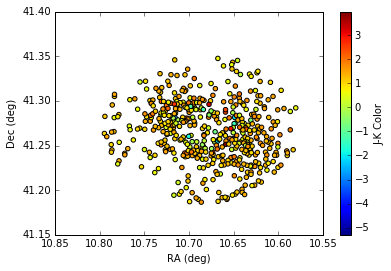

In [7]:
plt.scatter(t['ra'], t['dec'], c=t['j_k'])
plt.gca().invert_xaxis()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
color = plt.colorbar()
color.set_label('J-K Color')

## Simbad API

Now, let's have a look at [Simbad](http://simbad.u-strasbg.fr/simbad/) and use their [API](http://simbad.u-strasbg.fr/simbad/sim-help?Page=sim-url). There are a variety of URL available to us depending on what we want to do, we'll be using the most generalized one to send a custom-made script.

In [17]:
baseurl = 'http://simbad.u-strasbg.fr/simbad/sim-script'
script = """output console=off script=off
votable v1 {
MAIN_ID
COO
RA(d)
DEC(d)
OTYPE
}
votable open v1
sirius
query id V4046 Sgr
query coo 11 01 -34 42 radius=120s
votable close
"""
script = 'script=' + urllib.quote_plus(script)
url = baseurl + '?' +  script
print url

http://simbad.u-strasbg.fr/simbad/sim-script?script=output+console%3Doff+script%3Doff%0Avotable+v1+%7B%0AMAIN_ID%0ACOO%0ARA%28d%29%0ADEC%28d%29%0AOTYPE%0A%7D%0Avotable+open+v1%0Asirius%0Aquery+id+V4046+Sgr%0Aquery+coo+11+01+-34+42+radius%3D120s%0Avotable+close%0A


Up to now, with the parameters set in the URL, we've been issuing HTTP GET requests. That still works here, but there can be problems with very long URLs. To avoid this, we'll send the parameters via an HTTP POST requests. Some websites will treat GET and POST requests differently, but for our purposes this works fine and we don't need to worry about their differences for now.

In [19]:
response = urllib2.urlopen(baseurl, script)
u = response.read()
temp = StringIO(u)
try:
    t = Table.read(temp, format='votable')
    print t
except ValueError:
    print u

     MAIN_ID             RA           DEC      ...    DEC_d     OTYPE
                      "h:m:s"       "d:m:s"    ...     deg           
------------------ ------------- ------------- ... ------------ -----
         * alf CMa 06 45 08.9172 -16 42 58.017 ... -16.71611586    **
      V* V4046 Sgr 18 14 10.4660 -32 47 34.496 ... -32.79291560 BYDra
[HHP98] TW Hya X13   11 01 07.07   -34 41 19.3 ... -34.68869000     X


For a full list of fields to request from Simbad, as well as instructions on other Simbad queries, check out their [help page](http://simbad.u-strasbg.fr/simbad/sim-help?Page=sim-fscript).

## NASA ADS API

Next, let's have a look at the [NASA ADS](http://www.adsabs.harvard.edu/) API. Let's start with the old, classic way of searching for papers.

In [20]:
baseurl = 'http://adswww.harvard.edu/cgi-bin/basic_connect'
query = '^Rodriguez,D 2010-'
query = 'qsearch=' + urllib.quote_plus(query)
url = baseurl + '?' + query
print url

http://adswww.harvard.edu/cgi-bin/basic_connect?qsearch=%5ERodriguez%2CD+2010-


In [22]:
response = urllib2.urlopen(url, timeout=120)
u = response.read()

The result from this is just the ADS website. In order to get something out of this, we will parse it and grab the relevant information. We'll use [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/) to do this.

In [24]:
soup = BeautifulSoup(u, 'html.parser')
authors = soup.find_all('td', width='25%')
titles = soup.find_all('td', align="left", valign="top", colspan=3)
for i in range(len(authors)):
    print authors[i].get_text(), titles[i].string

Rodriguez, David R.; Zuckerman, B.; Kastner, Joel H.; Bessell, M. S.; Faherty, Jacqueline K.; Murphy, Simon J. The GALEX Nearby Young-Star Survey
Rodríguez, D.; Blaum, K.; Nörtershäuser, W.; Ahammed, M.; Algora, A.; Audi, G.; Äystö, J.; Beck, D.; Bender, M.; Billowes, J.; and 95 coauthors MATS and LaSpec: High-precision experiments using ion traps and lasers at FAIR
Rodriguez, David R.; Zuckerman, B. Binaries among Debris Disk Stars
Rodriguez, David R.; Bessell, M. S.; Zuckerman, B.; Kastner, Joel H. A New Method to Identify Nearby, Young, Low-mass Stars
Rodriguez, David R.; Kastner, Joel H.; Wilner, David; Qi, Chunhua Imaging the Molecular Disk Orbiting the Twin Young Suns of V4046 Sgr
Rodriguez, David R.; Duchêne, Gaspard; Tom, Henry; Kennedy, Grant M.; Matthews, Brenda; Greaves, Jane; Butner, Harold Stellar multiplicity and debris discs: an unbiased sample
Rodríguez, D.; Theofilis, V. Structural changes of laminar separation bubbles induced by global linear instability
Rodriguez, Da

It's good to know how to parse HTML and get useful information out of websites.
However, ADS has a new [interface](https://ui.adsabs.harvard.edu/) and a new way to call their [API](http://adsabs.github.io/help/api/). To access it, you'll need a personal authorization token which you can get on your user page when you log in. This token should be kept private.

In [42]:
my_token = 'TOKEN'

We'll be using the **[requests](http://docs.python-requests.org/en/latest/index.html)** package as that can deal with authorization to API, such as tokens and passwords. Anything we could do with **urllib**, we can pretty much do with **requests**.

In [26]:
baseurl = 'https://api.adsabs.harvard.edu/v1/search' + '/query'
my_search = {}
my_search['q'] = ['author:^Rodriguez,D','year:[2010 TO *]']  # the query
my_search['fl'] = 'bibcode,author,title,citation_count,pubdate' # what to output
my_search['sort'] = 'citation_count desc' # how to sort
my_search['rows'] = 20 # how many entries to return
my_auth = {'Authorization': 'Bearer:'+my_token}
r = requests.get(baseurl, params=my_search, headers=my_auth)

The output from such a request is a JSON (JavaScript Object Notation) formatted string.

In [27]:
r.json()

{u'response': {u'docs': [{u'author': [u'Rodriguez, David R.',
     u'Bessell, M. S.',
     u'Zuckerman, B.',
     u'Kastner, Joel H.'],
    u'bibcode': u'2011ApJ...727...62R',
    u'citation_count': 47,
    u'pubdate': u'2011-02-00',
    u'title': [u'A New Method to Identify Nearby, Young, Low-mass Stars']},
   {u'author': [u'Rodriguez, David R.', u'Zuckerman, B.'],
    u'bibcode': u'2012ApJ...745..147R',
    u'citation_count': 42,
    u'pubdate': u'2012-02-00',
    u'title': [u'Binaries among Debris Disk Stars']},
   {u'author': [u'Rodr\xedguez, D.',
     u'Kolhinen, V. S.',
     u'Audi, G.',
     u'\xc4yst\xf6, J.',
     u'Beck, D.',
     u'Blaum, K.',
     u'Bollen, G.',
     u'Herfurth, F.',
     u'Jokinen, A.',
     u'Kellerbauer, A.',
     u'Kluge, H. -J.',
     u'Oinonen, M.',
     u'Schatz, H.',
     u'Sauvan, E.',
     u'Schwarz, S.'],
    u'bibcode': u'2004PhRvL..93p1104R',
    u'citation_count': 38,
    u'pubdate': u'2004-10-00',
    u'title': [u'Mass Measurement on the rp-P

We'll use **simplejson** to parse the JSON information into something we can use.

In [29]:
data = simplejson.loads(r.text)['response']['docs']

for i in range(len(data)):
    if (data[i]['author'][0]!='Rodriguez, David R.'): continue
    print data[i]['bibcode'], data[i]['citation_count'], data[i]['pubdate'], data[i]['author'][0], data[i]['title'][0] 

2011ApJ...727...62R 47 2011-02-00 Rodriguez, David R. A New Method to Identify Nearby, Young, Low-mass Stars
2012ApJ...745..147R 42 2012-02-00 Rodriguez, David R. Binaries among Debris Disk Stars
2013ApJ...774..101R 33 2013-09-00 Rodriguez, David R. The GALEX Nearby Young-Star Survey
2010ApJ...720.1684R 31 2010-09-00 Rodriguez, David R. Imaging the Molecular Disk Orbiting the Twin Young Suns of V4046 Sgr
2012ApJ...748...30R 14 2012-03-00 Rodriguez, David R. A Substellar Companion to the Dusty Pleiades Star HD 23514
2011ApJ...732L..29R 9 2011-05-00 Rodriguez, David R. The Ultra Cool Brown Dwarf Companion of WD 0806-661B: Age, Mass, and Formation Mechanism
2014A&A...567A..20R 5 2014-07-00 Rodriguez, David R. A dusty M5 binary in the β Pictoris moving group


Refer to the [ADS API Github page](https://github.com/adsabs/adsabs-dev-api) for more examples of the sorts of searches you can do and the fields you can ask for.

## An Alternative Way

As an alternative to figuring out the URL and specifics for each API, you can consider the [Astroquery](http://astroquery.readthedocs.org/en/latest/index.html) package, which has built in support for a number of APIs (though for NASA ADS it is only the older omni-search box).   
For example, to query Simbad you could do:

In [30]:
from astroquery.simbad import Simbad
s = Simbad()
r = s.query_object('V4046 Sgr')
print r

  MAIN_ID          RA           DEC      ... COO_WAVELENGTH     COO_BIBCODE    
                "h:m:s"       "d:m:s"    ...                                   
------------ ------------- ------------- ... -------------- -------------------
V* V4046 Sgr 18 14 10.4660 -32 47 34.496 ...                1998A&A...335L..65H


## Twitter API

Finally, let's have a look at Twitter. While not exactly part of an astronomer's toolset, Twitter is often used in conferences to communicate with one another and with the public. Let's create a simple example where we access the API and get results for tweets about #astroHackNY.

You need special authorization ([OAuth](http://oauth.net/)) to query the [Twitter API](https://dev.twitter.com/overview/documentation). You'll need to go to Twitter's [Application Page](https://apps.twitter.com/), login with your account, and create an application. I've done this with my account and saved them to a file in JSON format, which I read below.

In [31]:
with open("twitter_secrets.json.nogit") as f:
    secrets = simplejson.loads(f.read())

# OAuth1 is a module in requests_oauthlib
auth = OAuth1(
    secrets["api_key"],
    secrets["api_secret"],
    secrets["access_token"],
    secrets["access_token_secret"]
)

Now we can structure our request in pretty much the same way as before.

In [40]:
params = {'q':'#AstroHackNY', 'result_type':'recent', 'count':20}
url = 'https://api.twitter.com/1.1/search/tweets.json'
r = requests.get(url, auth=auth, params=params)

In [41]:
data = simplejson.loads(r.text)['statuses']

for i in range(len(data)):
    print '%s (@%s): %s  (on %s)' % (data[i]['user']['name'], \
                                     data[i]['user']['screen_name'], data[i]['text'], data[i]['created_at'])

David Rodriguez (@Strakul): Just finished going through an iPython notebook on accessing APIs! https://t.co/4zILuBx8c4 #astroHackNY  (on Tue Feb 16 15:33:35 +0000 2016)
Emily Carlson (@emilyscarlson): will david's API work? #AstroHackNY  (on Tue Feb 16 15:32:20 +0000 2016)
Kelle Cruz (@kellecruz): for the record, this came up via @Strakul's API discussion at #astrohackny. @keflavich  (on Tue Feb 16 15:27:38 +0000 2016)
Kelle Cruz (@kellecruz): #astrohackny Why yes, yes it is. @davidwhogg “@nhuntwalker: @kellecruz Is this the droid you're looking for?  https://t.co/WjTnysBM4J”  (on Tue Feb 09 15:57:03 +0000 2016)
Kelle Cruz (@kellecruz): @nhuntwalker We can work on them during #astrohackny this semester! are they on github?  (on Tue Feb 09 15:36:53 +0000 2016)
Kelle Cruz (@kellecruz): #astrohackny Are there any ipython notebooks started to support the "fitting a line to data" paper? @exoplaneteer @adrianprw  (on Tue Feb 09 15:18:43 +0000 2016)


The Twitter API is quite complex, so I recommend experimenting and reading through their documentation.   
Note that Twitter searches are generally limited to one week of past tweets, so it can be tricky to find very old tweets.

In [35]:
url = 'https://api.twitter.com/1.1/statuses/update.json'
my_tweet = 'Just finished going through an iPython notebook on accessing APIs! https://github.com/dr-rodriguez/AstronomyAPI #astroHackNY'
r = requests.post(url, auth=auth, params={'status':my_tweet})

## Conclusion

There are many other APIs that you can go access. [Here is a list](http://dotastronomy.com/events/hackdays/nyc2012/apis/) of some astronomy-related ones, but the tools you learned here carry over to more general APIs as well. Now go forth and mine some data!

## Exercises

Want a little practice? How about the following:
1. Query the WISE database around 1 degree of some right ascension and declination that you pick. How many objects do you find?
2. There's certain to be some information for the sources that you found above. Query Simbad for all of them and find out which object has the most references.
3. For the object with the most references, what is the most cited publication?
4. Write a function that does all of the above. It should take a right ascension and declination as input and generate a message along the lines of: "For WISE sources within 1 degree of RA, DEC, OBJECT has NN publications, one of which has NN citations." Make sure that this is 140 characters long or less (trim as needed). This message should be posted to your Twitter account directly by your function.